# Model embeddings and similarity assignment

This notebook 

**What this notebook does:**
1. Loads a .csv containing species name and their backgrounds
2. Loads a subgraph with nodes meant to be specific to the model.
3. Generates embeddings on each side using a pre-trained BERT model
4. We compare embeddings from the species name/background to the node's enriched feature in the KG
5. We keep the best node in the graph and extract the code within the KG.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import networkx as nx
import pickle
from tqdm import tqdm
from torch_geometric.utils import from_networkx
import sys

import matplotlib.pyplot as plt

# # Set the logging level for httpx to WARNING to suppress INFO messages
import logging
logging.getLogger("httpx").setLevel(logging.WARNING)

/home/oneai/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
sys.path.append('../')
from aiagents4pharma.talk2knowledgegraphs.datasets.primekg import PrimeKG

In [2]:
local_dir = '../aiagents4pharma/talk2knowledgegraphs/tests/files/primekg_ibd_pyg_graph.pkl'

In [3]:
with open(local_dir, 'rb') as file:
    data = pickle.load(file)

data

Data(x=[3426, 768], edge_index=[2, 12752], edge_attr=[12752, 768], node_id=[3426], node_name=[3426], node_type=[3426], enriched_node=[3426], key=[12752], head_id=[12752], head_name=[12752], tail_id=[12752], tail_name=[12752], edge_type=[12752], enriched_edge=[12752])

In [4]:
G = nx.Graph()

# Add nodes to the graph
for i in range(len(data['node_id'])):
    G.add_node(
        data['node_id'][i],
        name=data['node_name'][i],
        type=data['node_type'][i],
        enriched_node=data['enriched_node'][i],
        features=data['x'][i].numpy(),  # You can add the node features as well
    )

# Add edges to the graph
for i in range(data['edge_index'].shape[1]):  # 12752 edges
    head = data['head_id'][i]
    tail = data['tail_id'][i]
    G.add_edge(
        head,
        tail,
        edge_attr=data['edge_attr'][i].numpy(),
        edge_type=data['edge_type'][i],
        enriched_edge=data['enriched_edge'][i]
    )

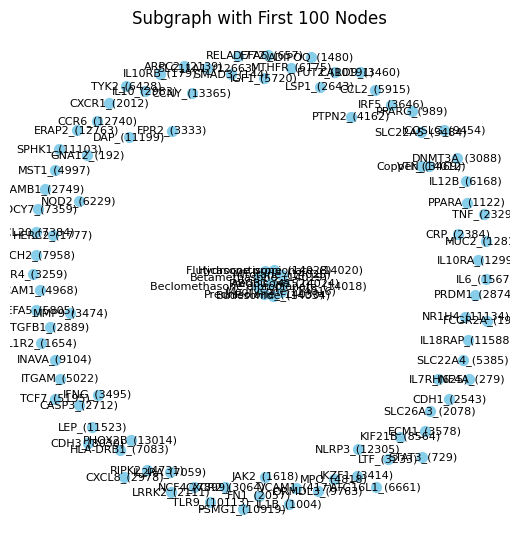

In [5]:
first_100_nodes = list(G.nodes)[:100]

subgraph = G.subgraph(first_100_nodes)

plt.figure(figsize=(5, 5))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8, node_color='skyblue')
plt.title("Subgraph with First 100 Nodes")
plt.show()


----------

### Bert model - transforming from text to tensor

In [6]:
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
import torch

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()  # Shape: (1, hidden_size)

# Example: Get embedding for a species description
text_description = """
    IL1B belongs to gene/protein category. The protein encoded by this gene is a member of the interleukin 1 cytokine family. This cytokine is produced by activated macrophages as a proprotein, which is proteolytically processed to its active form by caspase 1 (CASP1/ICE). This cytokine is an important mediator of the inflammatory response, and is involved in a variety of cellular activities, including cell proliferation, differentiation, and apoptosis. The induction of cyclooxygenase-2 (PTGS2/COX2) by this cytokine in the central nervous system (CNS) is found to contribute to inflammatory pain hypersensitivity. Similarly, IL-1B has been implicated in human osteoarthritis pathogenesis. Patients with severe Coronavirus Disease 2019 (COVID-19) present elevated levels of pro-inflammatory cytokines such as IL-1B in bronchial alveolar lavage fluid samples. The lung damage induced by the Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is to a large extent, a result of the inflammatory response promoted by cytokines such as IL-1B. This gene and eight other interleukin 1 family genes form a cytokine gene cluster on chromosome 2"""
text_embedding = get_text_embedding(text_description)


### Transform species into vectors

In [9]:
species_descriptions = pd.read_csv('species_backgrounds.csv')
res = []
for idx, row in species_descriptions.iterrows():
    res += [get_text_embedding(row['background'])]
species_descriptions['BERT_embedding'] = res

In [10]:
species_descriptions

,id,name,background,BERT_embedding
0,mwf626e95e_543f_41e4_aad4_c6bf60ab345b,IL6,"Based on the provided context, IL6 (interleuki...","[[-0.38310152, 0.14221658, 0.30036777, -0.1971..."
1,mwbbbce920_e8dd_4320_9386_fc94bfb2fc99,sgp130,"Based on the provided context, the species 'sg...","[[-0.39776802, 0.102813065, 0.276282, -0.17234..."
2,mw810ff751_fa4e_4143_bd50_169b3e325e1e,sR_IL6_sgp130,"Based on the provided context, 'sR_IL6_sgp130'...","[[-0.41926485, 0.05604683, 0.31495243, -0.0975..."
3,mw114aa90f_5f5b_4fe8_9406_361c8489b6a1,CRP,"Based on the provided context, CRP, or C-react...","[[-0.44731545, 0.21171626, 0.22573717, -0.1713..."
4,mw30ae63db_6cd3_4b6f_93ad_3350cd360bcc,sR,"From the provided documents, there is no speci...","[[-0.24422143, 0.22741008, 0.3196285, -0.20558..."
5,mw03db56ac_8dc6_4931_ae82_fef706d2ee3d,sR_IL6,Based on the provided context and general know...,"[[-0.38647282, 0.14947572, 0.37386724, -0.2257..."
6,mwf345ed7a_0622_403c_b816_c8749a2c9ded,Ab,The context provided from the documents appear...,"[[-0.35710102, 0.27481169, 0.15268518, -0.2598..."
7,mw1da111f2_a036_4392_8512_015005bdcbb7,Ab_sR,The context provided does not contain specific...,"[[-0.2979536, 0.22971633, 0.2543159, -0.238324..."
8,mw9947742a_0e4b_4636_9a4b_b6eef2a8f6ac,Ab_sR_IL6,"From the context provided, there is no direct ...","[[-0.3250525, 0.17176488, 0.2808889, -0.207119..."
9,CRP_Suppression___,CRP Suppression (%),"Based on the context provided, ""CRP Suppressio...","[[-0.47315472, 0.18459623, 0.24418907, -0.1895..."


### Graph behaviour

We pass each enriched node text through the BERT model to obtain an embedding

In [11]:
import gc

nodes_list = list(G.nodes)
total_len = len(nodes_list)
batch_size = 100 # for garbage collection

for node_idx in range(total_len):
    node = nodes_list[node_idx]
    print(f"{node_idx} / {total_len}")
    
    try:
        if 'enriched_node' in G.nodes[node]:
            text = G.nodes[node]['enriched_node']
            G.nodes[node]['BERT_embedding'] = get_text_embedding(text)
        else:
            print(f"Warning: 'enriched_node' not found for node {node}")
    except Exception as e:
        print(f"Error processing node {node}: {e}")
    
    if node_idx % batch_size == 0 and node_idx != 0:
        gc.collect()  # Force garbage collection to free memory


0 / 3426
1 / 3426
2 / 3426
3 / 3426
4 / 3426
5 / 3426
6 / 3426
7 / 3426
8 / 3426
9 / 3426
10 / 3426
11 / 3426
12 / 3426
13 / 3426
14 / 3426
15 / 3426
16 / 3426
17 / 3426
18 / 3426
19 / 3426
20 / 3426
21 / 3426
22 / 3426
23 / 3426
24 / 3426
25 / 3426
26 / 3426
27 / 3426
28 / 3426
29 / 3426
30 / 3426
31 / 3426
32 / 3426
33 / 3426
34 / 3426
35 / 3426
36 / 3426
37 / 3426
38 / 3426
39 / 3426
40 / 3426
41 / 3426
42 / 3426
43 / 3426
44 / 3426
45 / 3426
46 / 3426
47 / 3426
48 / 3426
49 / 3426
50 / 3426
51 / 3426
52 / 3426
53 / 3426
54 / 3426
55 / 3426
56 / 3426
57 / 3426
58 / 3426
59 / 3426
60 / 3426
61 / 3426
62 / 3426
63 / 3426
64 / 3426
65 / 3426
66 / 3426
67 / 3426
68 / 3426
69 / 3426
70 / 3426
71 / 3426
72 / 3426
73 / 3426
74 / 3426
75 / 3426
76 / 3426
77 / 3426
78 / 3426
79 / 3426
80 / 3426
81 / 3426
82 / 3426
83 / 3426
84 / 3426
85 / 3426
86 / 3426
87 / 3426
88 / 3426
89 / 3426
90 / 3426
91 / 3426
92 / 3426
93 / 3426
94 / 3426
95 / 3426
96 / 3426
97 / 3426
98 / 3426
99 / 3426
100 / 3426

### We add neighbor embeddings

In [12]:
proportions = [0.5, 0.15]  # example proportions for hops 1 and 2
neighbor_weight = 0

total_len = len(nodes_list)

# Loop through all nodes
for node_idx in range(total_len):
    print(node_idx)
    
    node_name = nodes_list[node_idx]
    node = G.nodes[node_name]
    embedding = node['BERT_embedding']

    
    weight = 0
    neighbor_embedding = np.array([np.zeros(len(embedding[0]))])
    
    seen_nodes = set([node_name])
    
    for prop_idx in range(len(proportions)):
        # Find neighbors N hops away
        nodes_n_hops_away = [
            neighbor for neighbor, dist in nx.single_source_shortest_path_length(G, node_name).items() 
            if dist == prop_idx + 1 and neighbor not in seen_nodes
        ]
        
        # Update the seen nodes with the current level's neighbors
        seen_nodes.update(nodes_n_hops_away)
        
        # Add the embeddings for these neighbors, weighted by proportion
        for neighbor_idx in nodes_n_hops_away:
            neighbor_node = G.nodes[neighbor_idx]
            neighbor_embedding += neighbor_node['BERT_embedding'] * proportions[prop_idx]
            weight += proportions[prop_idx]  # Add the weight of the current hop level

    # Normalize the final embedding by the total weight
    neighbor_embedding = neighbor_embedding / weight
    node['FINAL_embedding'] = (embedding + neighbor_embedding * neighbor_weight) / (1 + neighbor_weight)
    #print(f"Final embedding for node {node_name}: {node['FINAL_embedding']}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Obtain most similar embedding

In [13]:
def compare_species_in_graph(text_embedding, G, nodes_list):
    best_node = None
    best_sim = -1
    
    for node_name in nodes_list:
        curr_emb = G.nodes[node_name]['FINAL_embedding']
    
        curr_emb = curr_emb.flatten()
        text_embedding = text_embedding.flatten()
        
        sim = np.dot(curr_emb, text_embedding) / (np.linalg.norm(curr_emb) * np.linalg.norm(text_embedding))
        #sim = np.linalg.norm(curr_emb - text_embedding)
        if ((best_node is None) | (sim > best_sim)):
            best_node = node_name
            best_sim = sim
    return best_node, best_sim

In [14]:
res = []
for idx, row in species_descriptions.iterrows():
    best_node, best_sim = compare_species_in_graph(row['BERT_embedding'], G, nodes_list)
    res += [best_node]

species_descriptions['best_node'] = res

In [15]:
species_descriptions

,id,name,background,BERT_embedding,best_node
0,mwf626e95e_543f_41e4_aad4_c6bf60ab345b,IL6,"Based on the provided context, IL6 (interleuki...","[[-0.38310152, 0.14221658, 0.30036777, -0.1971...",CLEC7A (Dectin-1) signaling_(62768)
1,mwbbbce920_e8dd_4320_9386_fc94bfb2fc99,sgp130,"Based on the provided context, the species 'sg...","[[-0.39776802, 0.102813065, 0.276282, -0.17234...",Interleukin-2 signaling_(128499)
2,mw810ff751_fa4e_4143_bd50_169b3e325e1e,sR_IL6_sgp130,"Based on the provided context, 'sR_IL6_sgp130'...","[[-0.41926485, 0.05604683, 0.31495243, -0.0975...",Interleukin-6 signaling_(128814)
3,mw114aa90f_5f5b_4fe8_9406_361c8489b6a1,CRP,"Based on the provided context, CRP, or C-react...","[[-0.44731545, 0.21171626, 0.22573717, -0.1713...",Immunoregulatory interactions between a Lympho...
4,mw30ae63db_6cd3_4b6f_93ad_3350cd360bcc,sR,"From the provided documents, there is no speci...","[[-0.24422143, 0.22741008, 0.3196285, -0.20558...",G alpha (12/13) signalling events_(128349)
5,mw03db56ac_8dc6_4931_ae82_fef706d2ee3d,sR_IL6,Based on the provided context and general know...,"[[-0.38647282, 0.14947572, 0.37386724, -0.2257...",Interleukin-6 signaling_(128814)
6,mwf345ed7a_0622_403c_b816_c8749a2c9ded,Ab,The context provided from the documents appear...,"[[-0.35710102, 0.27481169, 0.15268518, -0.2598...",Interleukin-2 signaling_(128499)
7,mw1da111f2_a036_4392_8512_015005bdcbb7,Ab_sR,The context provided does not contain specific...,"[[-0.2979536, 0.22971633, 0.2543159, -0.238324...",Cytoprotection by HMOX1_(63064)
8,mw9947742a_0e4b_4636_9a4b_b6eef2a8f6ac,Ab_sR_IL6,"From the context provided, there is no direct ...","[[-0.3250525, 0.17176488, 0.2808889, -0.207119...",Interleukin-2 signaling_(128499)
9,CRP_Suppression___,CRP Suppression (%),"Based on the context provided, ""CRP Suppressio...","[[-0.47315472, 0.18459623, 0.24418907, -0.1895...",Immunoregulatory interactions between a Lympho...


-----------------

In [18]:
# Define primekg data by providing a local directory where the data is stored
primekg_data = PrimeKG(local_dir="../../data/primekg/")

# Invoke a method to load the data
primekg_data.load_data()

# Get primekg_nodes and primekg_edges
primekg_nodes = primekg_data.get_nodes()
primekg_edges = primekg_data.get_edges()

Loading nodes of PrimeKG dataset ...
../../data/primekg/primekg_nodes.tsv.gz already exists. Loading the data from the local directory.
Loading edges of PrimeKG dataset ...
../../data/primekg/primekg_edges.tsv.gz already exists. Loading the data from the local directory.


In [19]:
def fetch_code_in_graph(best_node, G):
    relevant_node_name = G.nodes[best_node]['name'].lower()
    query_str = f'node_name_lower.eq("{relevant_node_name}")'
    
    # Get the nodes related to IBD
    nodes_df = primekg_nodes.copy()
    nodes_df["node_name_lower"] = nodes_df.node_name.apply(lambda x: x.lower())
    nodes_df = nodes_df.query(query_str, engine='python')
    
    code = nodes_df.iloc[0]['node_id']
    
    return code

In [21]:
res = []
for idx, row in species_descriptions.iterrows():
    best_node = fetch_code_in_graph(row['best_node'], G)
    res += [best_node]

species_descriptions['best_code'] = res

In [22]:
species_descriptions

,id,name,background,BERT_embedding,best_node,best_code
0,mwf626e95e_543f_41e4_aad4_c6bf60ab345b,IL6,"Based on the provided context, IL6 (interleuki...","[[-0.38310152, 0.14221658, 0.30036777, -0.1971...",CLEC7A (Dectin-1) signaling_(62768),R-HSA-5607764
1,mwbbbce920_e8dd_4320_9386_fc94bfb2fc99,sgp130,"Based on the provided context, the species 'sg...","[[-0.39776802, 0.102813065, 0.276282, -0.17234...",Interleukin-2 signaling_(128499),R-HSA-9020558
2,mw810ff751_fa4e_4143_bd50_169b3e325e1e,sR_IL6_sgp130,"Based on the provided context, 'sR_IL6_sgp130'...","[[-0.41926485, 0.05604683, 0.31495243, -0.0975...",Interleukin-6 signaling_(128814),R-HSA-1059683
3,mw114aa90f_5f5b_4fe8_9406_361c8489b6a1,CRP,"Based on the provided context, CRP, or C-react...","[[-0.44731545, 0.21171626, 0.22573717, -0.1713...",Immunoregulatory interactions between a Lympho...,R-HSA-198933
4,mw30ae63db_6cd3_4b6f_93ad_3350cd360bcc,sR,"From the provided documents, there is no speci...","[[-0.24422143, 0.22741008, 0.3196285, -0.20558...",G alpha (12/13) signalling events_(128349),R-HSA-416482
5,mw03db56ac_8dc6_4931_ae82_fef706d2ee3d,sR_IL6,Based on the provided context and general know...,"[[-0.38647282, 0.14947572, 0.37386724, -0.2257...",Interleukin-6 signaling_(128814),R-HSA-1059683
6,mwf345ed7a_0622_403c_b816_c8749a2c9ded,Ab,The context provided from the documents appear...,"[[-0.35710102, 0.27481169, 0.15268518, -0.2598...",Interleukin-2 signaling_(128499),R-HSA-9020558
7,mw1da111f2_a036_4392_8512_015005bdcbb7,Ab_sR,The context provided does not contain specific...,"[[-0.2979536, 0.22971633, 0.2543159, -0.238324...",Cytoprotection by HMOX1_(63064),R-HSA-9707564
8,mw9947742a_0e4b_4636_9a4b_b6eef2a8f6ac,Ab_sR_IL6,"From the context provided, there is no direct ...","[[-0.3250525, 0.17176488, 0.2808889, -0.207119...",Interleukin-2 signaling_(128499),R-HSA-9020558
9,CRP_Suppression___,CRP Suppression (%),"Based on the context provided, ""CRP Suppressio...","[[-0.47315472, 0.18459623, 0.24418907, -0.1895...",Immunoregulatory interactions between a Lympho...,R-HSA-198933
